In [1]:
from itertools import product
from scipy.linalg import toeplitz
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [21]:
def get_real_data_dgp(rel_path, january=True, sd=1.0):
    data = pd.read_csv(rel_path)
    data = data.drop(["personal_id"], axis=1)

    if january:
        y = data[["vaccine_intention_jan"]]
        X = data.drop(["vaccine_intention_jan", "vaccine_intention_jul"], axis=1)
    else:
        y = data[["vaccine_intention_jul"]]
        X = data.drop(["vaccine_intention_jan", "vaccine_intention_jul"], axis=1)

    y_true_numpy = y.to_numpy()
    X_numpy = X.to_numpy()

    n, p = X_numpy.shape

    indices = np.random.permutation(n)
    fold_1_idx = indices[: int(n / 2)]
    X_fold_1 = X_numpy[fold_1_idx, :]
    y_fold_1 = y_true_numpy[fold_1_idx, :]


    # create random beta_vec
    #active_set = np.concatenate(
    #    (np.repeat(4, 1), np.repeat(-4, 1), np.repeat(1, 2), np.repeat(-1, 2), np.repeat(0.4, 5), np.repeat(0.1, 5))
    #)
    #inactive_set = np.zeros(p - len(active_set))

    #mixed_set = np.concatenate((active_set, inactive_set))
    #np.random.shuffle(mixed_set)
    #support = np.invert(np.isclose(np.zeros(p), mixed_set, atol=1e-06))
    #beta = mixed_set.reshape((p, 1))

    #y_artificial = X_numpy @ beta + np.random.normal(loc=0.0, scale=sd, size=n)
    #y_artificial = y_artificial.flatten()

    #Q1 = X.quantile(0.001)
    #Q3 = X.quantile(0.999)
    #IQR = Q3 - Q1

    #X_trunc = X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]
    #y_trunc = y_true_numpy[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]

    mod = sm.OLS(endog= y_fold_1, exog = X_fold_1)
    lin_reg = mod.fit()
    beta = lin_reg.params.reshape((len(lin_reg.params),1))
    
    beta[np.abs(beta) < 1.00e-1] = 0

    y_artificial = (X_numpy @ beta).flatten() + np.random.normal(loc=0.0, scale=sd, size=n)
    support = np.invert(np.isclose(np.zeros(p), beta.flatten(), atol=1e-06))

    return {
        "X": X_numpy,
        "y_true": y_true_numpy.flatten(),
        "y_artificial": y_artificial,
        "beta": beta,
        "support": support,
    }



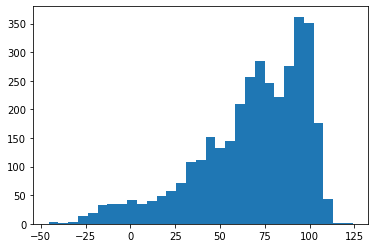

In [46]:
_ = plt.hist(dat["y_artificial"], bins='auto')
plt.show()

In [22]:
external_selectors = {'boruta_selector': boruta_selector,
                "univariate_feature_selection": univariate_feature_selection, 
                "lasso_feature_selection": lasso_feature_selection,
                "adaptive_lasso_tuned": adaptive_lasso_tuned}


number_simulations = 2
simulation_id = np.arange(number_simulations)
selectors = list(external_selectors.keys())

index = product(simulation_id, selectors)

index = pd.MultiIndex.from_tuples(
    index,
    names=("simulation_id", "selector"),
)

df = pd.DataFrame(columns=["share_of_truth_uncovered", 
                        "ratio_total_select_coeffs_true_coeffs",
                        "false_pos_share_true_support",
                        "false_pos_share_right_selection",
                        "linear_effect_coverage"], 
                            index=index)

In [10]:
df = pd.read_csv(os.path.abspath("../..") + "/bld/analysis/simulation_study_real_dgp_add_profession_yes_add_political_no.csv", index_col=["simulation_id","selector"])

In [11]:
df

share_of_truth_uncovered  \
simulation_id selector                                                 
0             boruta_selector                               0.169231   
              univariate_feature_selection                  1.000000   
              lasso_feature_selection                       0.107692   
              adaptive_lasso_tuned                          0.907692   
1             boruta_selector                               0.179104   
              univariate_feature_selection                  0.985075   
              lasso_feature_selection                       0.074627   
              adaptive_lasso_tuned                          0.865672   

                                            ratio_total_select_coeffs_true_coeffs  \
simulation_id selector                                                              
0             boruta_selector                                            0.169231   
              univariate_feature_selection                               1.230769   
              lasso_feature_selection                                    0.215385   
              adaptive_lasso_tuned                                       0.907692   
1             boruta_selector                                            0.208955   
              univariate_feature_selection                               1.194030   
              lasso_feature_selection                                    0.179104   
              adaptive_lasso_tuned                                       0.865672   

                                            false_pos_share_true_support  \
simulation_id selector                                                     
0             boruta_selector                                   0.000000   
              univariate_feature_selection                      0.230769   
              lasso_feature_selection                           0.107692   
              adaptive_lasso_tuned                              0.000000   
1             boruta_selector                                   0.029851   
              univariate_feature_selection                      0.208955   
              lasso_feature_selection                           0.104478   
              adaptive_lasso_tuned                              0.000000   

                                            false_pos_share_right_selection  \
simulation_id selector                                                        
0             boruta_selector                                      0.000000   
              univariate_feature_selection                         0.230769   
              lasso_feature_selection                              1.000000   
              adaptive_lasso_tuned                                 0.000000   
1             boruta_selector                                      0.166667   
              univariate_feature_selection                         0.212121   
              lasso_feature_selection                              1.400000   
              adaptive_lasso_tuned                                 0.000000   

                                            linear_effect_coverage  
simulation_id selector                                              
0             boruta_selector                             0.363636  
              univariate_feature_selection                0.937500  
              lasso_feature_selection                     0.357143  
              adaptive_lasso_tuned                        0.864407  
1             boruta_selector                             0.571429  
              univariate_feature_selection                0.862500  
              lasso_feature_selection                     0.416667  
              adaptive_lasso_tuned                        0.620690

In [23]:
for sim in df.index.get_level_values("simulation_id").unique():
    
    data = get_real_data_dgp(rel_path= os.path.abspath("../..") + "/bld/data/sparse_modelling_df_add_profession_no_add_political_no.csv", january=True, sd=1.0)
    X = data["X"]
    
    n, p = X.shape
    
    y = data["y_artificial"].reshape((len(data["y_artificial"]), 1))
    beta = data["beta"]
    true_support = data["support"]
    
    indices = np.random.permutation(n)
    fold_1_idx, fold_2_idx = indices[:int(n/2)], indices[int(n/2):]
    X_fold_1, X_fold_2 = X[fold_1_idx,:], X[fold_2_idx,:]
    y_fold_1, y_fold_2 = y[fold_1_idx,:], y[fold_2_idx,:]

    for select in df.index.get_level_values("selector").unique():
        if select != "adaptive_lasso_tuned":
            selected_support = external_selectors[select](X_fold=X_fold_1, y_fold=y_fold_1)
            conf_int = OLS_confidence_intervals(X_validation=X_fold_2, y_validation=y_fold_2, support=selected_support, intercept=False)

        else:
            res_dict = external_selectors[select](X=X, y=y, intercept=False, cross_valid_split=False)
            selected_support = res_dict["selected_support"]
            conf_int = res_dict["conf_intervals_nat"]
            
        selection_stats = selection_power(true_support=true_support, selected_support=selected_support)
        index_df = (sim, select)

        if conf_int.shape[0] == np.sum(selected_support):
            coverage = np.sum(true_params_in_conf_interval(true_theta_vec=beta[selected_support,:], conf_int_matrix=conf_int)) / np.sum(selected_support)
            df.at[index_df, "linear_effect_coverage"] = coverage

        df.at[index_df, "share_of_truth_uncovered"] = selection_stats["share_of_truth_uncovered"]
        df.at[index_df, "ratio_total_select_coeffs_true_coeffs"] = selection_stats["ratio_total_select_coeffs_true_coeffs"]
        df.at[index_df, "false_pos_share_true_support"] = selection_stats["false_pos_share_true_support"]
        df.at[index_df, "false_pos_share_right_selection"] = selection_stats["false_pos_share_right_selection"]

# df.to_csv(produces, index_label=["simulation_id", "n_obs", "identity_cov_matrix", "p_features", "link_function", "selector"])

In [16]:
df.groupby(['selector']).mean()

DataError: No numeric types to aggregate

In [267]:
dgp_functions = {'linear_link': linear_link,
            "polynomial_link": polynomial_link, 
             "sine_link": sine_link}
external_selectors = {'boruta_selector': boruta_selector,
            "univariate_feature_selection": univariate_feature_selection, 
             "lasso_feature_selection": lasso_feature_selection,
             "adaptive_lasso_tuned": adaptive_lasso_tuned}

In [302]:
n = [100, 2000]
number_simulations = 1
simulation_id = np.arange(number_simulations)
identity = [True, False]
p = [20, 80]
link_functions = list(dgp_functions.keys())
selectors = list(external_selectors.keys())
index = product(simulation_id, n, identity, p, link_functions, selectors)

index = pd.MultiIndex.from_tuples(
    index,
    names=("simulation_id", "n_obs", "identity_cov_matrix", "p_features", "link_function", "selector"),
)

df = pd.DataFrame(columns=["share_of_truth_uncovered", 
                           "ratio_total_select_coeffs_true_coeffs",
                           "false_pos_share_true_support",
                           "false_pos_share_right_selection",
                           "linear_effect_coverage",
                           "conf_int_width"], 
                            index=index)


In [303]:
df

share_of_truth_uncovered  \
simulation_id n_obs identity_cov_matrix p_features link_function   selector                                                
0             100   True                20         linear_link     boruta_selector                                   NaN   
                                                                   univariate_feature_selection                      NaN   
                                                                   lasso_feature_selection                           NaN   
                                                                   adaptive_lasso_tuned                              NaN   
                                                   polynomial_link boruta_selector                                   NaN   
...                                                                                                                  ...   
              1000  False               80         polynomial_link adaptive_lasso_tuned                              NaN   
                                                   sine_link       boruta_selector                                   NaN   
                                                                   univariate_feature_selection                      NaN   
                                                                   lasso_feature_selection                           NaN   
                                                                   adaptive_lasso_tuned                              NaN   

                                                                                                ratio_total_select_coeffs_true_coeffs  \
simulation_id n_obs identity_cov_matrix p_features link_function   selector                                                             
0             100   True                20         linear_link     boruta_selector                                                NaN   
                                                                   univariate_feature_selection                                   NaN   
                                                                   lasso_feature_selection                                        NaN   
                                                                   adaptive_lasso_tuned                                           NaN   
                                                   polynomial_link boruta_selector                                                NaN   
...                                                                                                                               ...   
              1000  False               80         polynomial_link adaptive_lasso_tuned                                           NaN   
                                                   sine_link       boruta_selector                                                NaN   
                                                                   univariate_feature_selection                                   NaN   
                                                                   lasso_feature_selection                                        NaN   
                                                                   adaptive_lasso_tuned                                           NaN   

                                                                                                false_pos_share_true_support  \
simulation_id n_obs identity_cov_matrix p_features link_function   selector                                                    
0             100   True                20         linear_link     boruta_selector                                       NaN   
                                                                   univariate_feature_selection                          NaN   
                                                                   lasso_feature_selection                               NaN   
                                                             

In [304]:
%%time
for sim in df.index.get_level_values("simulation_id").unique():
    for n in df.index.get_level_values("n_obs").unique():
        for ident in df.index.get_level_values("identity_cov_matrix").unique():
            for p in df.index.get_level_values("p_features").unique():
                for link in df.index.get_level_values("link_function").unique():
                    dgp = get_artificial_dgp(n=n, p=p, link_function=dgp_functions[link], identity_cov=ident)
                    X = dgp["X"]
                    y = dgp["y"]
                    beta = dgp["beta"]
                    true_support = np.invert(np.isclose(np.zeros(p), beta.flatten(), atol=1e-06))
                    indices = np.random.permutation(n)
                    fold_1_idx, fold_2_idx = indices[:int(n/2)], indices[int(n/2):]
                    X_fold_1, X_fold_2 = X[fold_1_idx,:], X[fold_2_idx,:]
                    y_fold_1, y_fold_2 = y[fold_1_idx,:], y[fold_2_idx,:]

                    for select in df.index.get_level_values("selector").unique():
                        if select != "adaptive_lasso_tuned":
                            selected_support = external_selectors[select](X_fold=X_fold_1, y_fold=y_fold_1)
                            conf_int = OLS_confidence_intervals(X_validation=X_fold_2, y_validation=y_fold_2, support=selected_support, intercept=True)

                        else:
                            res_dict = external_selectors[select](X=X, y=y)
                            selected_support = res_dict["selected_support"]
                            conf_int = res_dict["conf_intervals_nat"]

                        selection_stats = selection_power(true_support=true_support, selected_support=selected_support)
                        index_df = (sim, n, ident, p, link, select)

                        if selected_support[0]:
                            coverage = true_params_in_conf_interval(true_theta_vec=beta[selected_support,:], conf_int_matrix=conf_int)
                            df.at[index_df, "linear_effect_coverage"] = coverage[0]
                            df.at[index_df, "conf_int_width"] = conf_int[0,:].flatten()
                        else:
                            df.at[index_df, "linear_effect_coverage"] = np.nan
                            df.at[index_df, "conf_int_width"] = np.nan

                        df.at[index_df, "share_of_truth_uncovered"] = selection_stats["share_of_truth_uncovered"]
                        df.at[index_df, "ratio_total_select_coeffs_true_coeffs"] = selection_stats["ratio_total_select_coeffs_true_coeffs"]
                        df.at[index_df, "false_pos_share_true_support"] = selection_stats["false_pos_share_true_support"]
                        df.at[index_df, "false_pos_share_right_selection"] = selection_stats["false_pos_share_right_selection"]


CPU times: user 10min 40s, sys: 6min 52s, total: 17min 33s
Wall time: 2min 51s


In [2]:
df40 = pd.read_csv(os.path.abspath("../..") + "/bld/analysis/simulation_study_artificial_dgps_40.csv", index_col=["simulation_id", "n_obs", "identity_cov_matrix", "p_features", "link_function", "selector"])

In [3]:
df10 = pd.read_csv(os.path.abspath("../..") + "/bld/analysis/simulation_study_artificial_dgps.csv", index_col=["simulation_id", "n_obs", "identity_cov_matrix", "p_features", "link_function", "selector"])

In [4]:
df10.index = df10.index.set_levels(np.arange(start=40, stop=50, step=1), level=0)

In [5]:
result = pd.concat([df40,df10])

In [8]:
result.to_csv(os.path.abspath("../..") + "/bld/analysis/simulation_study_artificial_results.csv", index_label=["simulation_id", "n_obs", "identity_cov_matrix", "p_features", "link_function", "selector"])

In [6]:
result.groupby(['identity_cov_matrix', 'n_obs', 'p_features', 'link_function', 'selector']).mean().head(45)

share_of_truth_uncovered  \
identity_cov_matrix n_obs p_features link_function   selector                                                 
False               100   20         linear_link     adaptive_lasso_tuned                             0.734   
                                                     boruta_selector                                  0.450   
                                                     lasso_feature_selection                          0.904   
                                                     univariate_feature_selection                     0.866   
                                     polynomial_link adaptive_lasso_tuned                             0.182   
                                                     boruta_selector                                  0.154   
                                                     lasso_feature_selection                          0.074   
                                                     univariate_feature_selection                     0.152   
                                     sine_link       adaptive_lasso_tuned                             0.112   
                                                     boruta_selector                                  0.136   
                                                     lasso_feature_selection                          0.224   
                                                     univariate_feature_selection                     0.140   
                          80         linear_link     adaptive_lasso_tuned                             0.746   
                                                     boruta_selector                                  0.362   
                                                     lasso_feature_selection                          0.792   
                                                     univariate_feature_selection                     0.492   
                                     polynomial_link adaptive_lasso_tuned                             0.164   
                                                     boruta_selector                                  0.102   
                                                     lasso_feature_selection                          0.060   
                                                     univariate_feature_selection                     0.116   
                                     sine_link       adaptive_lasso_tuned                             0.138   
                                                     boruta_selector                                  0.116   
                                                     lasso_feature_selection                          0.130   
                                                     univariate_feature_selection                     0.104   
                    2000  20         linear_link     adaptive_lasso_tuned                             0.904   
                                                     boruta_selector                                  0.706   
                                                     lasso_feature_selection                          0.958   
                                                     univariate_feature_selection                     0.920   
                                     polynomial_link adaptive_lasso_tuned                             0.644   
                                                     boruta_selector                                  0.526   
                                                     lasso_feature_selection                          0.680   
                                                     univariate_feature_selection                     0.508   
                                     sine_link       adaptive_lasso_tuned                             0.206   
                                                     boruta_selector                                  0.138   
                                                     lasso_feature_selection           

In [8]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LassoCV

from boruta import BorutaPy


def boruta_selector(X_fold, y_fold):    
    rf = RandomForestRegressor(n_jobs=-1, n_estimators= 500, max_depth=6, random_state=0)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)
    feat_selector.fit(X_fold, y_fold.flatten())
    return feat_selector.support_
    
def univariate_feature_selection(X_fold, y_fold):
    n, p = X_fold.shape
    if 1.5*n <= p:
        upper = int(p/3)
    else:
        upper = p

    pipe = Pipeline([('scaler', StandardScaler()),
                 ('selector', SelectKBest(f_regression, k=5)),
                 ('final_regression', LinearRegression())])
    search_space = [{'selector__k': np.arange(start = 1 , stop = upper)}]
    grid_res = GridSearchCV(pipe, search_space, cv=2, verbose=0)
    grid_res = grid_res.fit(X_fold, y_fold.flatten())
    k_opt = grid_res.best_params_["selector__k"]

    support = SelectKBest(f_regression, k= k_opt).fit(X_fold, y_fold.flatten()).get_support()
    return support


def lasso_feature_selection(X_fold, y_fold, folds=2, intercept=True):
    n, p = X.shape
    reg = LassoCV(cv=folds, random_state=0, fit_intercept=intercept).fit(X_fold, y_fold.flatten())
    coeffs = reg.coef_
    support = np.invert(np.isclose(np.zeros(p), coeffs, atol=1e-06))
    return support


def OLS_confidence_intervals(X_validation, y_validation, support, intercept=True):

    X_supp = X_validation[:,support]

    if intercept:
        X_supp = sm.add_constant(X_supp)

    mod = sm.OLS(endog= y_validation.flatten(), exog = X_supp)
    res = mod.fit()
    if intercept:
        conf_int = np.delete(res.conf_int(), 0, 0)
    else:
        conf_int = res.conf_int()
    return conf_int


def get_real_data_dgp(rel_path, january=True, sd=1.0):
    data = pd.read_csv(rel_path)
    data = data.drop(["personal_id"], axis=1)

    if january:
        y = data[["vaccine_intention_jan"]]
        X = data.drop(["vaccine_intention_jan", "vaccine_intention_jul"], axis=1)
    else:
        y = data[["vaccine_intention_jul"]]
        X = data.drop(["vaccine_intention_jan", "vaccine_intention_jul"], axis=1)

    y_true_numpy = y.to_numpy()
    X_numpy = X.to_numpy()

    n, p = X_numpy.shape

    indices = np.random.permutation(n)
    fold_1_idx = indices[: int(n / 2)]
    X_fold_1 = X_numpy[fold_1_idx, :]
    y_fold_1 = y_true_numpy[fold_1_idx, :]


    # create random beta_vec
    #active_set = np.concatenate(
    #    (np.repeat(4, 1), np.repeat(-4, 1), np.repeat(1, 2), np.repeat(-1, 2), np.repeat(0.4, 5), np.repeat(0.1, 5))
    #)
    #inactive_set = np.zeros(p - len(active_set))

    #mixed_set = np.concatenate((active_set, inactive_set))
    #np.random.shuffle(mixed_set)
    #support = np.invert(np.isclose(np.zeros(p), mixed_set, atol=1e-06))
    #beta = mixed_set.reshape((p, 1))

    #y_artificial = X_numpy @ beta + np.random.normal(loc=0.0, scale=sd, size=n)
    #y_artificial = y_artificial.flatten()

    #Q1 = X.quantile(0.001)
    #Q3 = X.quantile(0.999)
    #IQR = Q3 - Q1

    #X_trunc = X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]
    #y_trunc = y_true_numpy[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]

    mod = sm.OLS(endog= y_fold_1, exog = X_fold_1)
    lin_reg = mod.fit()
    beta = lin_reg.params.reshape((len(lin_reg.params),1))

    y_artificial = (X_numpy @ beta).flatten() + np.random.normal(loc=0.0, scale=sd, size=n)
    support = np.invert(np.isclose(np.zeros(p), beta.flatten(), atol=1e-06))

    return {
        "X": X_numpy,
        "y_true": y_true_numpy.flatten(),
        "y_artificial": y_artificial,
        "beta": beta,
        "support": support,
    }


In [9]:
import numpy as np
from numba import njit
from sklearn.linear_model import LinearRegression
from scipy import linalg

@njit
def count_non_zero_coeffs(theta_vec):
    s = 0
    for i in theta_vec:
        if np.abs(i) > 1e-04:
            s += 1
    return s


def soft_threshold(rho, lamda, w):
    """Soft threshold function used for normalized data and lasso regression"""
    if rho < -lamda * w:
        return rho + lamda * w
    elif rho > lamda * w:
        return rho - lamda * w
    else:
        return 0


@njit
def soft_threshold_numba(rho, lamda, w):
    if rho < -lamda * w:
        return rho + lamda * w
    elif rho > lamda * w:
        return rho - lamda * w
    else:
        return 0.0


@njit
def get_lamda_path_numba(X, y):
    epsilon = 0.0001
    K = 100
    m, p = X.shape

    y = y.reshape((m, 1))
    sx = X
    sy = y

    lambda_max = np.max(np.abs(np.sum(sx * sy, axis=0))) / m
    lamda_path = np.exp(
        np.linspace(np.log(lambda_max), np.log(lambda_max * epsilon), np.int64(K))
    )

    return lamda_path


def get_lamda_path(X, y, epsilon=0.0001, K=100):
    m, p = X.shape

    y = y.reshape((m, 1))
    sx = X
    sy = y
    
    if 0.5 * m <= p:
        epsilon = 0.01
        
    lambda_max = np.max(np.abs(np.sum(sx * sy, axis=0))) / m
    lamda_path = np.exp(
        np.linspace(
            start=np.log(lambda_max), stop=np.log(lambda_max * epsilon), num=np.int64(K)
        )
    )

    return lamda_path


def update_coeffs(
    X, y, theta, active_set, penalty_factors, intercept, lamda, thresh, active_thresh
):
    active_set_converged_check = np.full((len(active_set),), False)
    active_set_update = np.full((len(active_set),), True)

    for subindex, j in enumerate(active_set):
        w_j = penalty_factors[j]
        X_j = X[:, j].reshape(-1, 1)

        y_pred = X @ theta
        rho = X_j.T @ (y - y_pred + theta[j] * X_j)
        z = np.sum(np.square(X_j))

        if intercept:
            if j == 0:
                tmp = rho / z
                if np.abs(tmp) < active_thresh:
                    active_set_update[subindex] = False
                if np.abs(theta[j] - tmp) < thresh:
                    active_set_converged_check[subindex] = True
                theta[j] = tmp
            else:
                tmp = (1 / z) * soft_threshold(rho, lamda, w_j)
                if np.abs(tmp) < active_thresh:
                    active_set_update[subindex] = False
                if np.abs(theta[j] - tmp) < thresh:
                    active_set_converged_check[subindex] = True
                theta[j] = tmp

        else:
            tmp = (1 / z) * soft_threshold(rho, lamda, w_j)
            if np.abs(tmp) < active_thresh:
                active_set_update[subindex] = False
            if np.abs(theta[j] - tmp) < thresh:
                active_set_converged_check[subindex] = True
            theta[j] = tmp

    active_set_converged = np.all(active_set_converged_check)
    active_set = active_set[active_set_update]

    return [theta, active_set, active_set_converged]


def naive_lasso(
    X,
    y,
    penalty_factors=None,
    theta=None,
    lamda_path=None,
    num_iters=100,
    intercept=True,
):

    m, p = X.shape

    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)

    y_mean = np.mean(y)
    y_std = np.std(y)

    X = (X - x_mean) / x_std
    y = (y - y_mean) / y_std

    if lamda_path is None:
        path = m * get_lamda_path_numba(X=X, y=y)
    else:
        path = m * lamda_path

    if intercept:
        X = np.insert(X, 0, 1, axis=1)

    m, p = X.shape

    if theta is None:
        theta = np.zeros((p, 1))

    if penalty_factors is None:
        penalty_factors = np.ones((p, 1))

    result = []
    for lamda in path:
        theta = np.zeros((p, 1))
        output = {}
        output["lamda"] = lamda / m

        for _i in range(num_iters):
            for j in range(p):
                w_j = penalty_factors[j]
                X_j = X[:, j].reshape(-1, 1)

                y_pred = X @ theta
                rho = X_j.T @ (y - y_pred + theta[j] * X_j)
                z = np.sum(np.square(X_j))

                if intercept:
                    if j == 0:
                        theta[j] = rho / z
                    else:
                        theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)

                else:
                    theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)

        if not intercept:
            theta_nat = theta.flatten() / x_std * y_std
        if intercept:
            theta_0 = (
                theta.flatten()[0] - np.sum((x_mean / x_std) * theta.flatten()[1:])
            ) * y_std + y_mean
            theta_betas = theta.flatten()[1:] / x_std * y_std
            theta_nat = np.insert(arr=theta_betas, obj=0, values=theta_0)

        output["theta_std"] = theta.flatten()
        output["theta_nat"] = theta_nat
        result.append(output)
    return result


def eps_thresh_lasso(
    X,
    y,
    penalty_factors=None,
    theta=None,
    lamda_path=None,
    num_iters=100,
    intercept=True,
    thresh=1e-7,
):

    m, p = X.shape

    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)

    y_mean = np.mean(y)
    y_std = np.std(y)

    X = (X - x_mean) / x_std
    y = (y - y_mean) / y_std

    if lamda_path is None:
        path = m * get_lamda_path_numba(X=X, y=y)
    else:
        path = m * lamda_path

    if intercept:
        X = np.insert(X, 0, 1, axis=1)

    m, p = X.shape

    if theta is None:
        theta = np.zeros((p, 1))

    if penalty_factors is None:
        penalty_factors = np.ones((p, 1))

    result = []
    for lamda in path:
        theta = np.zeros((p, 1))
        output = {}
        output["lamda"] = lamda / m
        tol_vals = np.full((p,), False)

        for _i in range(num_iters):
            if not np.all(tol_vals):
                for j in range(p):
                    w_j = penalty_factors[j]
                    X_j = X[:, j].reshape(-1, 1)

                    y_pred = X @ theta
                    rho = X_j.T @ (y - y_pred + theta[j] * X_j)
                    z = np.sum(np.square(X_j))

                    if intercept:
                        if j == 0:
                            if np.abs(theta[j] - rho / z) < thresh:
                                tol_vals[j] = True
                            theta[j] = rho / z
                        else:
                            if (
                                np.abs(
                                    theta[j] - (1 / z) * soft_threshold(rho, lamda, w_j)
                                )
                                < thresh
                            ):
                                tol_vals[j] = True
                            theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)

                    else:
                        if (
                            np.abs(theta[j] - (1 / z) * soft_threshold(rho, lamda, w_j))
                            < thresh
                        ):
                            tol_vals[j] = True
                        theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)
            else:
                break

        if not intercept:
            theta_nat = theta.flatten() / x_std * y_std
        if intercept:
            theta_0 = (
                theta.flatten()[0] - np.sum((x_mean / x_std) * theta.flatten()[1:])
            ) * y_std + y_mean
            theta_betas = theta.flatten()[1:] / x_std * y_std
            theta_nat = np.insert(arr=theta_betas, obj=0, values=theta_0)

        output["theta_std"] = theta.flatten()
        output["theta_nat"] = theta_nat
        result.append(output)

    return result


def eps_thresh_lasso_warm_start(
    X,
    y,
    penalty_factors=None,
    theta=None,
    lamda_path=None,
    num_iters=100,
    intercept=True,
    thresh=1e-7,
    warm_start=True,
):
    """Coordinate gradient descent for lasso regression - for standardized data """

    m, p = X.shape
    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)

    y_mean = np.mean(y)
    y_std = np.std(y)

    X = (X - x_mean) / x_std
    y = (y - y_mean) / y_std

    if lamda_path is None:
        path = m * get_lamda_path_numba(X=X, y=y)
    else:
        path = m * lamda_path

    if intercept:
        X = np.insert(X, 0, 1, axis=1)

    m, p = X.shape

    if theta is None:
        theta = np.zeros((p, 1))

    if penalty_factors is None:
        penalty_factors = np.ones((p, 1))

    result = []
    for lamda in path:
        if not warm_start:
            theta = np.zeros((p, 1))
        output = {}
        output["lamda"] = lamda / m
        tol_vals = np.full((p,), False)

        for _i in range(num_iters):
            if not np.all(tol_vals):
                for j in range(p):
                    w_j = penalty_factors[j]
                    X_j = X[:, j].reshape(-1, 1)

                    y_pred = X @ theta
                    rho = X_j.T @ (y - y_pred + theta[j] * X_j)
                    z = np.sum(np.square(X_j))

                    if intercept:
                        if j == 0:
                            if np.abs(theta[j] - rho / z) < thresh:
                                tol_vals[j] = True
                            theta[j] = rho / z
                        else:
                            if (
                                np.abs(
                                    theta[j] - (1 / z) * soft_threshold(rho, lamda, w_j)
                                )
                                < thresh
                            ):
                                tol_vals[j] = True
                            theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)

                    else:
                        if (
                            np.abs(theta[j] - (1 / z) * soft_threshold(rho, lamda, w_j))
                            < thresh
                        ):
                            tol_vals[j] = True
                        theta[j] = (1 / z) * soft_threshold(rho, lamda, w_j)
            else:
                break

        if not intercept:
            theta_nat = theta.flatten() / x_std * y_std
        if intercept:
            theta_0 = (
                theta.flatten()[0] - np.sum((x_mean / x_std) * theta.flatten()[1:])
            ) * y_std + y_mean
            theta_betas = theta.flatten()[1:] / x_std * y_std
            theta_nat = np.insert(arr=theta_betas, obj=0, values=theta_0)

        output["theta_std"] = theta.flatten()
        output["theta_nat"] = theta_nat
        result.append(output)

    return result


def active_set_lasso(
    X,
    y,
    penalty_factors=None,
    theta=None,
    lamda_path=None,
    num_iters=100,
    intercept=True,
    thresh=1e-7,
    active_thresh=1e-7,
    warm_start=True,
):

    m, p = X.shape

    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)

    y_mean = np.mean(y)
    y_std = np.std(y)

    X = (X - x_mean) / x_std
    y = (y - y_mean) / y_std

    if lamda_path is None:
        path = m * get_lamda_path_numba(X=X, y=y)
    else:
        path = m * lamda_path

    if intercept:
        X = np.insert(X, 0, 1, axis=1)

    m, p = X.shape

    if theta is None:
        theta = np.zeros((p, 1))

    if penalty_factors is None:
        penalty_factors = np.ones((p, 1))

    result = []
    for lamda in path:
        if not warm_start:
            theta = np.zeros((p, 1))
        output = {}
        output["lamda"] = lamda / m
        sec_check_all_converged = False
        active_set = np.arange(p)
        active_set_converged = False

        for _i in range(num_iters):
            if (active_set.size != 0) and (not active_set_converged):
                theta, active_set, active_set_converged = update_coeffs(
                    X=X,
                    y=y,
                    theta=theta,
                    active_set=active_set,
                    penalty_factors=penalty_factors,
                    intercept=intercept,
                    lamda=lamda,
                    thresh=thresh,
                    active_thresh=active_thresh,
                )
            elif not sec_check_all_converged:
                active_set = np.arange(p)
                theta, active_set, active_set_converged = update_coeffs(
                    X=X,
                    y=y,
                    theta=theta,
                    active_set=active_set,
                    penalty_factors=penalty_factors,
                    intercept=intercept,
                    lamda=lamda,
                    thresh=thresh,
                    active_thresh=active_thresh,
                )

                if active_set_converged:
                    sec_check_all_converged = True
                    break
            else:
                break

        if not intercept:
            theta_nat = theta.flatten() / x_std * y_std
        if intercept:
            theta_0 = (
                theta.flatten()[0] - np.sum((x_mean / x_std) * theta.flatten()[1:])
            ) * y_std + y_mean
            theta_betas = theta.flatten()[1:] / x_std * y_std
            theta_nat = np.insert(arr=theta_betas, obj=0, values=theta_0)

        output["theta_std"] = theta.flatten()
        output["theta_nat"] = theta_nat
        result.append(output)

    return result


@njit
def lasso_numba(
    X,
    y,
    lamda_path=None,
    penalty_factors=None,
    theta=None,
    num_iters=100,
    intercept=True,
    thresh=1e-7,
    active_thresh=1e-7,
    warm_start=True,
):

    m, p = X.shape

    x_mean = np.zeros((p,), dtype=np.float64)

    for i in range(p):
        x_mean[i] = X[:, i].mean()

    x_std = np.zeros((p,), dtype=np.float64)

    for i in range(p):
        x_std[i] = X[:, i].std()

    y_mean = np.mean(y)
    y_std = np.std(y)

    X_standardized = (X - x_mean) / x_std
    y_standardized = (y - y_mean) / y_std

    if intercept:
        X_tmp = np.ones((m, p + 1))
        X_tmp[:, 1:] = X
        X = X_tmp

    if lamda_path is None:
        path = m * get_lamda_path_numba(X=X_standardized, y=y_standardized)
    else:
        path = m * lamda_path

    if intercept:
        X_tmp = np.ones((m, p + 1))
        X_tmp[:, 1:] = X_standardized
        X_standardized = X_tmp

    m, p = X_standardized.shape

    if theta is None:
        theta = np.zeros((p, 1))

    if penalty_factors is None:
        penalty_factors = np.ones((p, 1))

    lamdas = []
    thetas = []
    thetas_nat = []
    BIC = []

    for lamda in path:
        if not warm_start:
            theta = np.zeros((p, 1))
        sec_check_all_converged = False
        active_set = np.arange(p)
        active_set_converged = False

        for _i in range(num_iters):
            if (active_set.size != 0) and (not active_set_converged):
                active_set_converged_check = np.full((len(active_set),), False)
                active_set_update = np.full((len(active_set),), True)

                for subindex, j in enumerate(active_set):
                    w_j = penalty_factors[j].item()

                    y_pred = X_standardized @ theta

                    rho = 0.0
                    z = 0.0

                    for obs in range(m):
                        rho += X_standardized[obs, j].item() * (
                            y_standardized[obs].item()
                            - y_pred[obs].item()
                            + theta[j].item() * X_standardized[obs, j].item()
                        )
                        z += np.square(X_standardized[obs, j].item())

                    if intercept:
                        if j == 0:
                            tmp = rho / z
                            if np.abs(tmp) < active_thresh:
                                active_set_update[subindex] = False
                            if np.abs(theta[j] - tmp) < thresh:
                                active_set_converged_check[subindex] = True
                            theta[j] = tmp
                        else:
                            tmp = (1 / z) * soft_threshold_numba(rho, lamda, w_j)
                            if np.abs(tmp) < active_thresh:
                                active_set_update[subindex] = False
                            if np.abs(theta[j] - tmp) < thresh:
                                active_set_converged_check[subindex] = True
                            theta[j] = tmp

                    else:
                        tmp = (1 / z) * soft_threshold_numba(rho, lamda, w_j)
                        if np.abs(tmp) < active_thresh:
                            active_set_update[subindex] = False
                        if np.abs(theta[j] - tmp) < thresh:
                            active_set_converged_check[subindex] = True
                        theta[j] = tmp

                active_set_converged = np.all(active_set_converged_check)
                active_set = active_set[active_set_update]

            elif not sec_check_all_converged:
                active_set = np.arange(p)

                active_set_converged_check = np.full((len(active_set),), False)
                active_set_update = np.full((len(active_set),), True)

                m, p = X_standardized.shape

                for subindex, j in enumerate(active_set):
                    w_j = penalty_factors[j].item()

                    y_pred = X_standardized @ theta
                    rho = 0.0
                    z = 0.0

                    for obs in range(m):
                        rho += X_standardized[obs, j].item() * (
                            y_standardized[obs].item()
                            - y_pred[obs].item()
                            + theta[j].item() * X_standardized[obs, j].item()
                        )
                        z += np.square(X_standardized[obs, j].item())

                    if intercept:
                        if j == 0:
                            tmp = rho / z
                            if np.abs(tmp) < active_thresh:
                                active_set_update[subindex] = False
                            if np.abs(theta[j] - tmp) < thresh:
                                active_set_converged_check[subindex] = True
                            theta[j] = tmp
                        else:
                            tmp = (1 / z) * soft_threshold_numba(rho, lamda, w_j)
                            if np.abs(tmp) < active_thresh:
                                active_set_update[subindex] = False
                            if np.abs(theta[j] - tmp) < thresh:
                                active_set_converged_check[subindex] = True
                            theta[j] = tmp

                    else:
                        tmp = (1 / z) * soft_threshold_numba(rho, lamda, w_j)
                        if np.abs(tmp) < active_thresh:
                            active_set_update[subindex] = False
                        if np.abs(theta[j] - tmp) < thresh:
                            active_set_converged_check[subindex] = True
                        theta[j] = tmp

                active_set_converged = np.all(active_set_converged_check)
                active_set = active_set[active_set_update]

                if active_set_converged:
                    sec_check_all_converged = True
                    break
            else:
                break

        if not intercept:
            theta_tmp = theta.flatten() / x_std * y_std
        if intercept:
            theta_0 = (
                theta.flatten()[0] - np.sum((x_mean / x_std) * theta.flatten()[1:])
            ) * y_std + y_mean
            theta_betas = theta.flatten()[1:] / x_std * y_std
            theta_tmp = np.ones((p,))
            theta_tmp[1:] = theta_betas
            theta_tmp[0] = theta_0

        m, p = X.shape
        theta_bic = np.ones((p, 1))
        theta_bic[:, 0] = theta_tmp
        residuals_hat = np.sum(np.square(y - X @ theta_bic))
        df_lamda = count_non_zero_coeffs(theta_vec=theta_bic.flatten())
        BIC_lasso = residuals_hat / (m * y_std ** 2) + np.log(m) / m * df_lamda

        lamdas.append(lamda / m)
        thetas.append(np.copy(theta).flatten())
        thetas_nat.append(theta_tmp)
        BIC.append(BIC_lasso)

    return lamdas, thetas, thetas_nat, BIC


def adaptive_lasso(
    X,
    y,
    intercept=True,
    lamda_path=None,
    gamma_path=None,
    first_stage="OLS",
    num_iters=100,
    out_as_df = True
):

    m, p = X.shape

    if gamma_path is None:
        path_gamma = np.array([0.001, 0.01, 0.1, 0.5, 1, 2, 3, 4, 6, 8])
    else:
        path_gamma = gamma_path

    if first_stage == "OLS":
        reg = LinearRegression(fit_intercept=intercept).fit(X, y)
        coeffs = reg.coef_.T
    elif first_stage == "Lasso":
        res = lasso_numba(X=X, y=y)

        index_lamda_opt = np.where(res[3] == np.amin(res[3]))[0][0]
        coeffs = np.delete(res[1][index_lamda_opt], 0).reshape((p, 1))

    else:
        raise AssertionError(
            "This feature has so far only been implemented for OLS and Lasso as its first-stage estimators."
        )

    coeffs[np.abs(coeffs) < 1.00e-15] = 1.00e-15
    
    results = []
    weight_path = []
    for gamma in path_gamma:

        if intercept:
            weights = np.ones((p + 1, 1))
            weights[1:, :] = 1.0 / np.abs(coeffs) ** gamma
        else:
            weights = 1.0 / np.abs(coeffs) ** gamma

        res = lasso_numba(
            X,
            y,
            lamda_path=lamda_path,
            penalty_factors=weights,
            theta=None,
            num_iters=num_iters,
            intercept=intercept,
            thresh=1e-7,
            active_thresh=1e-7,
            warm_start=True,
        )
        
        weight_path.append(weights)
        results.append(res)

    if out_as_df:
        lamda_p = results[0][0]
        df = pd.DataFrame(list(product(path_gamma, lamda_p)), columns=['gamma', 'lamda'])
        df["theta_std"] = np.nan
        df["theta_nat"] = np.nan
        df["gamma_weights"] = np.nan
        df = df.astype(object)
        df = df.set_index(['gamma', 'lamda'])

        for id_gamma, gamma in enumerate(path_gamma):
            for idx, lamda in enumerate(lamda_p):
                index = (gamma, lamda)
                df.at[index, "theta_std"] = results[id_gamma][1][idx]
                df.at[index, "theta_nat"] = results[id_gamma][2][idx]
                df.at[index, "gamma_weights"] = weight_path[id_gamma]
        return df

    else:
        return path_gamma, results, weight_path


def get_conf_intervals(
    lamda, weights, theta_std, theta_nat, X, X_std, intercept, y, y_std
):
    n, p = X.shape
    if intercept:
        X_with_intercept = np.insert(X, 0, 1, axis=1)
        X_std_with_intercept = np.insert(X_std, 0, 1, axis=1)

        sigma_hat_nat = (
            1
            / n
            * np.sum(
                np.square(y - X_with_intercept @ theta_nat.reshape((len(theta_nat), 1)))
            )
        )
        sigma_hat_std = (
            1
            / n
            * np.sum(
                np.square(
                    y_std
                    - X_std_with_intercept @ theta_std.reshape((len(theta_std), 1))
                )
            )
        )
    else:
        sigma_hat_nat = (
            1 / n * np.sum(np.square(y - X @ theta_nat.reshape((len(theta_nat), 1))))
        )
        sigma_hat_std = (
            1
            / n
            * np.sum(np.square(y_std - X_std @ theta_std.reshape((len(theta_std), 1))))
        )

    if intercept:
        theta_std = np.delete(arr=theta_std, obj=0)
        theta_nat = np.delete(arr=theta_nat, obj=0)
        weights = np.delete(arr=weights, obj=0, axis=0)

    weights = weights.flatten()

    active_set = np.invert(np.isclose(np.zeros(p), theta_nat, atol=1e-06))

    X_active = X[:, active_set]
    X_std_active = X_std[:, active_set]
    theta_nat_active = theta_nat[active_set]
    theta_std_active = theta_std[active_set]
    weights_active = weights[active_set]

    diag_std = weights_active / theta_std_active
    diag_nat = weights_active / theta_nat_active

    sigma_beta_std = np.diag(v=diag_std, k=0)
    sigma_beta_nat = np.diag(v=diag_nat, k=0)

    main_mat_nat = X_active.T @ X_active + lamda * sigma_beta_nat
    main_mat_std = X_std_active.T @ X_std_active + lamda * sigma_beta_std

    main_mat_nat_inverse = linalg.inv(main_mat_nat)
    main_mat_std_inverse = linalg.inv(main_mat_std)

    beta_hat_nat_cov_mat = sigma_hat_nat * (
        main_mat_nat_inverse @ X_active.T @ X_active @ main_mat_nat_inverse
    )
    beta_hat_std_cov_mat = sigma_hat_std * (
        main_mat_std_inverse @ X_std_active.T @ X_std_active @ main_mat_std_inverse
    )

    conf_intervals_nat_upper_bound = theta_nat_active + 1.96 * np.sqrt(
        np.diag(beta_hat_nat_cov_mat)
    )
    conf_intervals_nat_lower_bound = theta_nat_active - 1.96 * np.sqrt(
        np.diag(beta_hat_nat_cov_mat)
    )

    conf_intervals_nat = np.column_stack(
        (conf_intervals_nat_lower_bound, conf_intervals_nat_upper_bound)
    )

    conf_intervals_std_upper_bound = theta_std_active + 1.96 * np.sqrt(
        np.diag(beta_hat_std_cov_mat)
    )
    conf_intervals_std_lower_bound = theta_std_active - 1.96 * np.sqrt(
        np.diag(beta_hat_std_cov_mat)
    )

    conf_intervals_std = np.column_stack(
        (conf_intervals_std_lower_bound, conf_intervals_std_upper_bound)
    )

    return {
        "beta_hat_nat_cov_mat": beta_hat_nat_cov_mat,
        "beta_hat_std_cov_mat": beta_hat_std_cov_mat,
        "conf_intervals_nat": conf_intervals_nat,
        "conf_intervals_std": conf_intervals_std,
        "active_set": active_set,
    }


def make_prediction(X, y, theta_nat, intercept=True):
    if intercept:
        X = np.insert(X, 0, 1, axis=1)
        
    y_hat = X @ theta_nat.reshape((X.shape[1],1))
    mse = np.sum(np.square(y - y_hat))
    return y_hat, mse


def cv_adaptive_lasso(X, y, intercept=True, first_stage="OLS", cross_valid_split = True):
    n, p = X.shape

    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)

    y_mean = np.mean(y)
    y_std = np.std(y)

    X_standardized = (X - x_mean) / x_std
    y_standardized = (y - y_mean) / y_std

    indices = np.random.permutation(n)
    fold_1_idx, fold_2_idx = indices[: int(n / 2)], indices[int(n / 2) :]
    X_fold_1, X_fold_2 = X[fold_1_idx, :], X[fold_2_idx, :]
    y_fold_1, y_fold_2 = y[fold_1_idx, :], y[fold_2_idx, :]

    gamma_path = np.array([0.5, 1, 2, 3, 4, 6, 8, 10])
    lamda_path = get_lamda_path(X=X_standardized, y=y_standardized)

    trained_on_fold_1 = adaptive_lasso(
        X=X_fold_1,
        y=y_fold_1,
        intercept=intercept,
        lamda_path=lamda_path,
        gamma_path=gamma_path,
        first_stage=first_stage,
        num_iters=100,
        out_as_df=True,
    )

    if cross_valid_split:
        trained_on_fold_2 = adaptive_lasso(
            X=X_fold_2,
            y=y_fold_2,
            intercept=intercept,
            lamda_path=lamda_path,
            gamma_path=gamma_path,
            first_stage=first_stage,
            num_iters=100,
            out_as_df=True,
        )

        trained_on_fold_1["mse_1"] = np.nan
        trained_on_fold_2["mse_2"] = np.nan

        prod = product(
            trained_on_fold_1.index.get_level_values("gamma").unique(),
            trained_on_fold_1.index.get_level_values("lamda").unique(),
        )
        for gamma, lamda in prod:
            index = (gamma, lamda)
            y_hat_1, mse_1 = make_prediction(
                X=X_fold_2,
                y=y_fold_2,
                theta_nat=trained_on_fold_1.at[index, "theta_nat"],
                intercept=intercept,
            )

            y_hat_2, mse_2 = make_prediction(
                X=X_fold_1,
                y=y_fold_1,
                theta_nat=trained_on_fold_2.at[index, "theta_nat"],
                intercept=intercept,
            )

            trained_on_fold_1.at[index, "mse_1"] = mse_1
            trained_on_fold_2.at[index, "mse_2"] = mse_2

        cv_overview = trained_on_fold_1.merge(
            trained_on_fold_2, how="left", on=["gamma", "lamda"]
        )[["mse_1", "mse_2"]]
        cv_overview["mean_mse"] = cv_overview.mean(axis=1)

        params_opt = cv_overview.iloc[
            cv_overview["mean_mse"].argmin(),
        ].name

    else:
        trained_on_fold_1["mse_1"] = np.nan
        prod = product(trained_on_fold_1.index.get_level_values('gamma').unique(),trained_on_fold_1.index.get_level_values('lamda').unique())
        for gamma, lamda in prod:
            index = (gamma, lamda)
            y_hat_1, mse_1 = make_prediction(X= X_fold_2, 
                            y=y_fold_2,
                            theta_nat= trained_on_fold_1.at[index, "theta_nat"],
                            intercept = intercept)

            trained_on_fold_1.at[index, "mse_1"] = mse_1

        cv_overview = trained_on_fold_1[['mse_1']]

        params_opt = cv_overview.iloc[cv_overview['mse_1'].argmin(),].name

    return cv_overview, params_opt


def adaptive_lasso_tuned(X, y, first_stage="OLS", intercept=True, cross_valid_split = True):
    n, p = X.shape

    x_mean = X.mean(axis=0)
    x_std = X.std(axis=0)

    y_mean = np.mean(y)
    y_std = np.std(y)

    X_standardized = (X - x_mean) / x_std
    y_standardized = (y - y_mean) / y_std

    cv_results, params_opt = cv_adaptive_lasso(
        X=X, y=y, intercept=intercept, first_stage=first_stage, cross_valid_split= cross_valid_split
    )
    gamma_opt = params_opt[0]
    lamda_opt = params_opt[1]

    train_opt_ada_lasso = adaptive_lasso(
        X=X,
        y=y,
        intercept=intercept,
        lamda_path=np.array([lamda_opt]),
        gamma_path=np.array([gamma_opt]),
        first_stage=first_stage,
        num_iters=100,
        out_as_df=True,
    )

    ada_lasso_opt_res = get_conf_intervals(
        lamda=lamda_opt,
        weights=train_opt_ada_lasso.iloc[0]["gamma_weights"],
        theta_std=train_opt_ada_lasso.iloc[0]["theta_std"],
        theta_nat=train_opt_ada_lasso.iloc[0]["theta_nat"],
        X=X,
        X_std=X_standardized,
        intercept=intercept,
        y=y,
        y_std=y_standardized,
    )

    selected_support = ada_lasso_opt_res["active_set"]
    conf_intervals_nat = ada_lasso_opt_res["conf_intervals_nat"]
    conf_intervals_std = ada_lasso_opt_res["conf_intervals_std"]

    return {
        "selected_support": selected_support,
        "conf_intervals_nat": conf_intervals_nat,
        "conf_intervals_std": conf_intervals_std,
    }

In [10]:
from scipy.stats import random_correlation
from sklearn.preprocessing import StandardScaler
# from statsmodels.stats.moment_helpers import corr2cov

from scipy.linalg import toeplitz
import pandas as pd
import numpy

def toeplitz_cov(p, rho):
    first_col_toeplitz = np.repeat(rho, p)
    exponents = np.arange(p)
    first_col_toeplitz = first_col_toeplitz**exponents

    return toeplitz(c=first_col_toeplitz)

# both of these choices of covariance matrices satisfy the strong irrepresentability condition
def get_cov_mat(p, identity):
    if identity:
        return np.identity(p)
    else:
        return toeplitz_cov(p=p, rho=0.8)
        
def get_X_mat(n, p, identity_cov, seed=1):
    assert p > 10
    
    #np.random.seed(seed=seed)
    
    if identity_cov:
        return np.random.multivariate_normal(mean=np.repeat(0, repeats=p), cov=get_cov_mat(p=p, identity=identity_cov), size= n)
    else:
        return np.random.multivariate_normal(mean=np.repeat(0, repeats=p), cov=get_cov_mat(p=p, identity=identity_cov), size = n)
    
def get_true_beta_vec(p):
    assert p > 10
    return np.insert(arr=np.zeros((p - 10,)), obj=0, values=np.array([  1.,   0.5,   1.,  -1, -0.1,  -0.5,  0.01, -0.05,  -1.5,  1.5])).reshape((p,1))


def linear_link(X, beta):
    return X @ beta

def polynomial_link(X, beta):
    n, p = X.shape
    
    linear_effect = X[:,0].reshape((n,1)) @ beta[0,:].reshape((1,1))
    residual = X[:,1:] @ beta[1:,:].reshape((p-1,1))
    
    return linear_effect + (residual)**2 + (residual) + 1

def sine_link(X, beta):
    n, p = X.shape
    
    linear_effect = X[:,0].reshape((n,1)) @ beta[0,:].reshape((1,1))
    residual = X[:,1:] @ beta[1:,:].reshape((p-1,1))
    
    return linear_effect + np.sin(2*residual) + np.sin(residual) + 1


def get_artificial_dgp(n, p, link_function, identity_cov=True):
    
    X = get_X_mat(n=n, p=p, identity_cov=True, seed=1)
    beta_vec = get_true_beta_vec(p=p)
    
    y = link_function(X, beta_vec).flatten() + np.random.normal(loc=0.0, scale=0.5, size=n)
    y = y.reshape((len(y), 1))
    return {"X": X, "y": y, "beta": beta_vec}



In [11]:
import numpy as np 
import pandas as pd 


def selection_power(true_support, selected_support):
    count_true_support = np.sum(true_support)
    count_selected_support = np.sum(selected_support)
    res = np.logical_and(true_support, selected_support)
    truth_uncovered = np.sum(res)
    ratio_selected_true = count_selected_support / count_true_support
    share_of_truth_uncovered = truth_uncovered / count_true_support

    false_positives = np.full((len(true_support),), False, dtype=bool)
    for idx, val in enumerate(selected_support):
        if val:
            if not true_support[idx]:
                false_positives[idx] = True
    
    false_pos_share_true_support = np.sum(false_positives) / count_true_support
    if truth_uncovered != 0:
        false_pos_share_right_selection = np.sum(false_positives) / truth_uncovered
    else:
        false_pos_share_right_selection = np.nan

    return {"share_of_truth_uncovered": share_of_truth_uncovered,
            "ratio_total_select_coeffs_true_coeffs": ratio_selected_true,
            "false_pos_share_true_support": false_pos_share_true_support,
            "false_pos_share_right_selection": false_pos_share_right_selection}


def true_params_in_conf_interval(true_theta_vec, conf_int_matrix):
    coverage = np.greater(true_theta_vec,conf_int_matrix[:,0].reshape((conf_int_matrix.shape[0], 1))) & np.less(true_theta_vec,conf_int_matrix[:,1].reshape((conf_int_matrix.shape[0], 1)))
    return coverage.flatten()
